In [1]:
import tensorflow as tf
import numpy as np
import os,math,re,sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #CPU Only

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'#GPU Running

import matplotlib.pylab as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
AUTO = tf.data.experimental.AUTOTUNE
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [38]:
IMG_SIZE = [224,224]
IMG_CHANNELS = 3

BATCH_SIZE = 32


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) #JPEG --> Tensor
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.reshape(image, [*IMG_SIZE, 3])
    image = tf.image.resize(image, IMG_SIZE) #image must be 3-D, so resize it
    return image

def read_tfrecord(example):
    image_feature_dict = {
        'image':tf.io.FixedLenFeature([],tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, image_feature_dict) #return a dict
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int64) - 1 #5 classes in[0,4]
    return image,label   #return a tuple

def load_dataset(filenames, ordered = False):
    ignore_order = tf.data.Options()

    if not ordered:
        ignore_order.deterministic = False # experimental_deterministic has been baned

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def get_training_dataset():
    dataset = load_dataset('Training_Set.tfrecord') #ordered default is False
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) #Prepare later elements
    return dataset

def get_validation_dataset(ordered = False):
    dataset = load_dataset('Evaluation_Set.tfrecord', ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache() #cache files in memory
    dataset = dataset.prefetch(AUTO)
    return dataset

In [39]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training label examples:", label.numpy())
labelarray = label.numpy()
print(labelarray[0],type(labelarray[0]))
imagearray = image.numpy()
print(imagearray[0], type(imagearray[0]))

Training data shapes:
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
Training label examples: [4 1 0 0 4 4 2 2 3 3 2 3 0 1 2 4 0 3 1 2 4 0 0 2 1 2 3 3 1 0 3 0]
4 <class 'numpy.int64'>
[[[0.34297958 0.49199924 0.44886196]
  [0.35966992 0.5086895  0.4655523 ]
  [0.37318662 0.51436305 0.46730426]
  ...
  [0.4639356  0.58879554 0.5381303 ]
  [0.44816178 0.5775736  0.53443635]
  [0.41556376 0.5567402  0.5096814 ]]

 [[0.36754805 0.51656765 0.46765313]
  [0.38061973 0.52963936 0.48072478]
  [0.39658162 0.52932423 0.4844577 ]
  ...
  [0.48443633 0.60952836 0.55816674]
  [0.46281514 0.5951156  0.5433124 ]
  [0.43599445 0.57139355 0.5185574 ]]

 [[0.38156512 0.528799   0.47692576]
  [0.39724228 0.53933823 0.49003395]
  [0.41620976 0.54497206 0.49931896]
  ...
  [0.5029429  0.62708163 0.5739005 ]
  [0.47629553 0.60784316 0.5520484 ]
  [0.45243353 0.5839811  0.52818626]]

 ...

 [[0.36568886 0.51587135 0.4335184 ]
  [0.3906686  0.52970934 0.45068267]
  [0.40747356 0.53517

In [40]:
CLASSES = ['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']

training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20) #20 images, 20 labels in every batch 
train_batch = iter(training_dataset)

for image, label in train_batch:
    print(image.numpy().shape, label.numpy().shape)
    print(type(image.numpy()), type(label.numpy()))
    print(label.numpy())
    break

(20, 224, 224, 3) (20,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[2 3 2 4 2 4 3 0 4 3 4 3 1 2 1 4 1 4 0 3]


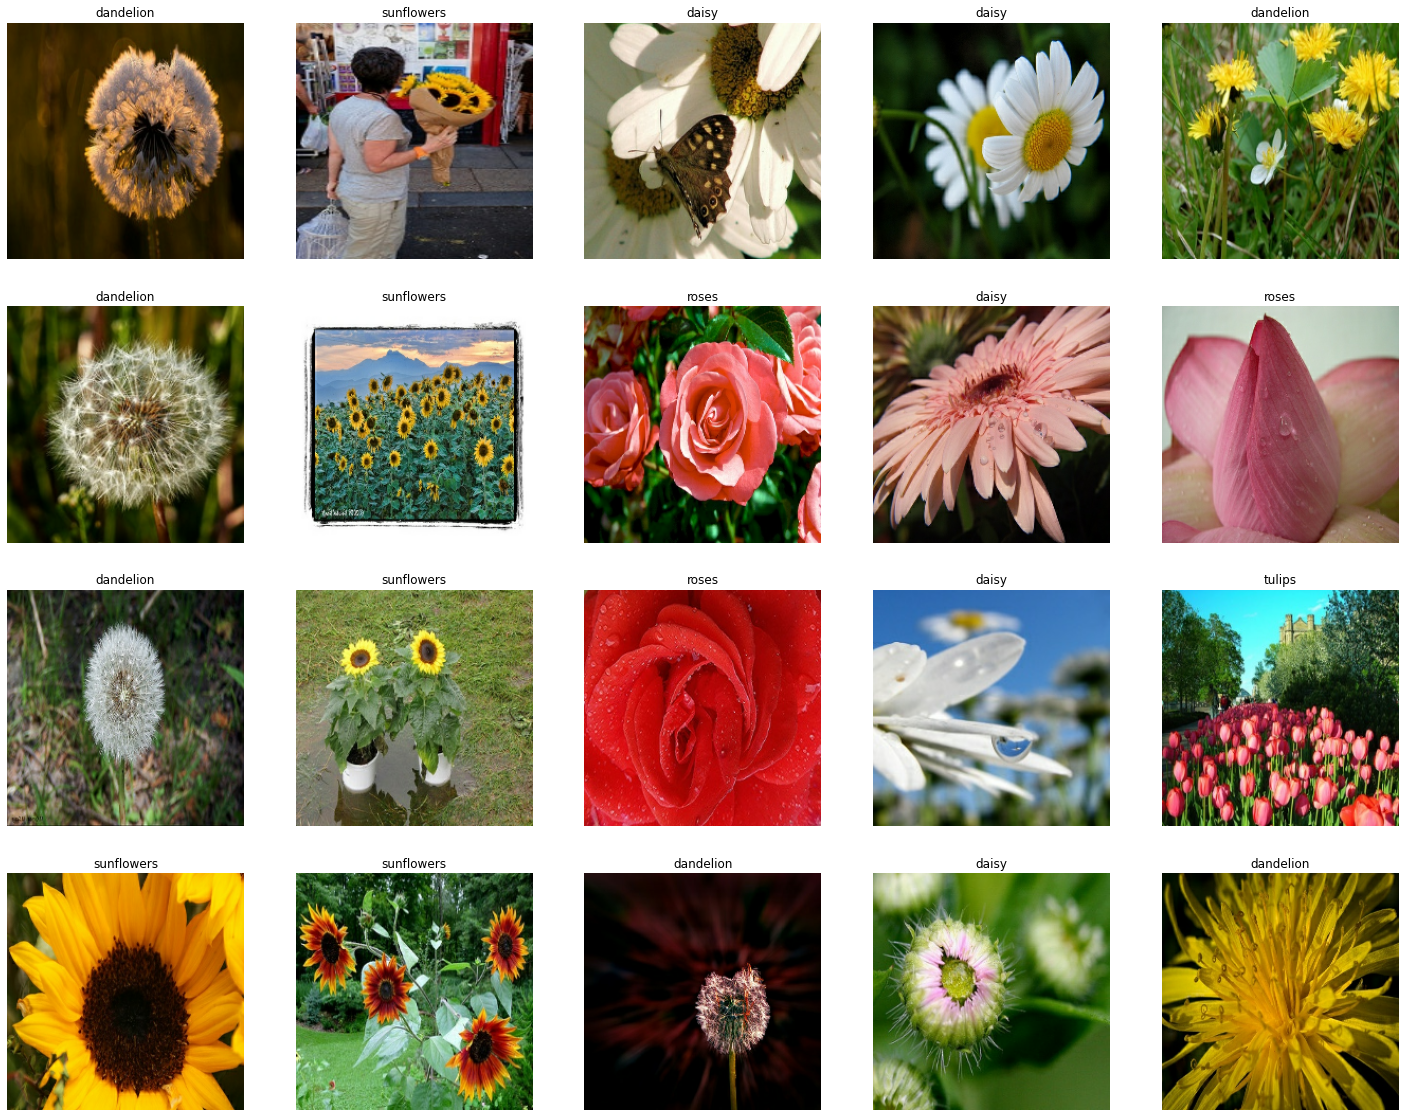

In [41]:
image_batch, label_batch = next(train_batch) # accept the first batch
label_batch = label_batch.numpy()

plt.figure(figsize=(25, 20)) #the size of whole figure
for i in range(20):
  ax = plt.subplot(4, 5, i+1) #the whole figure has 4 rows, 5 columns figures, this is i+1 figure
  #plt.imshow(image_batch[i].numpy().astype("uint8"))  #when image Tensor is the type of Uint8
  plt.imshow(image_batch[i].numpy())
  index = label_batch[i]  #5 classes in[0,4]
  plt.title(CLASSES[index])
  plt.axis("off")

2022-04-13 13:26:58.533587: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(20, 224, 224, 3) (20,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[2 0 0 1 1 2 3 4 3 3 4 0 3 4 0 2 3 1 3 3]


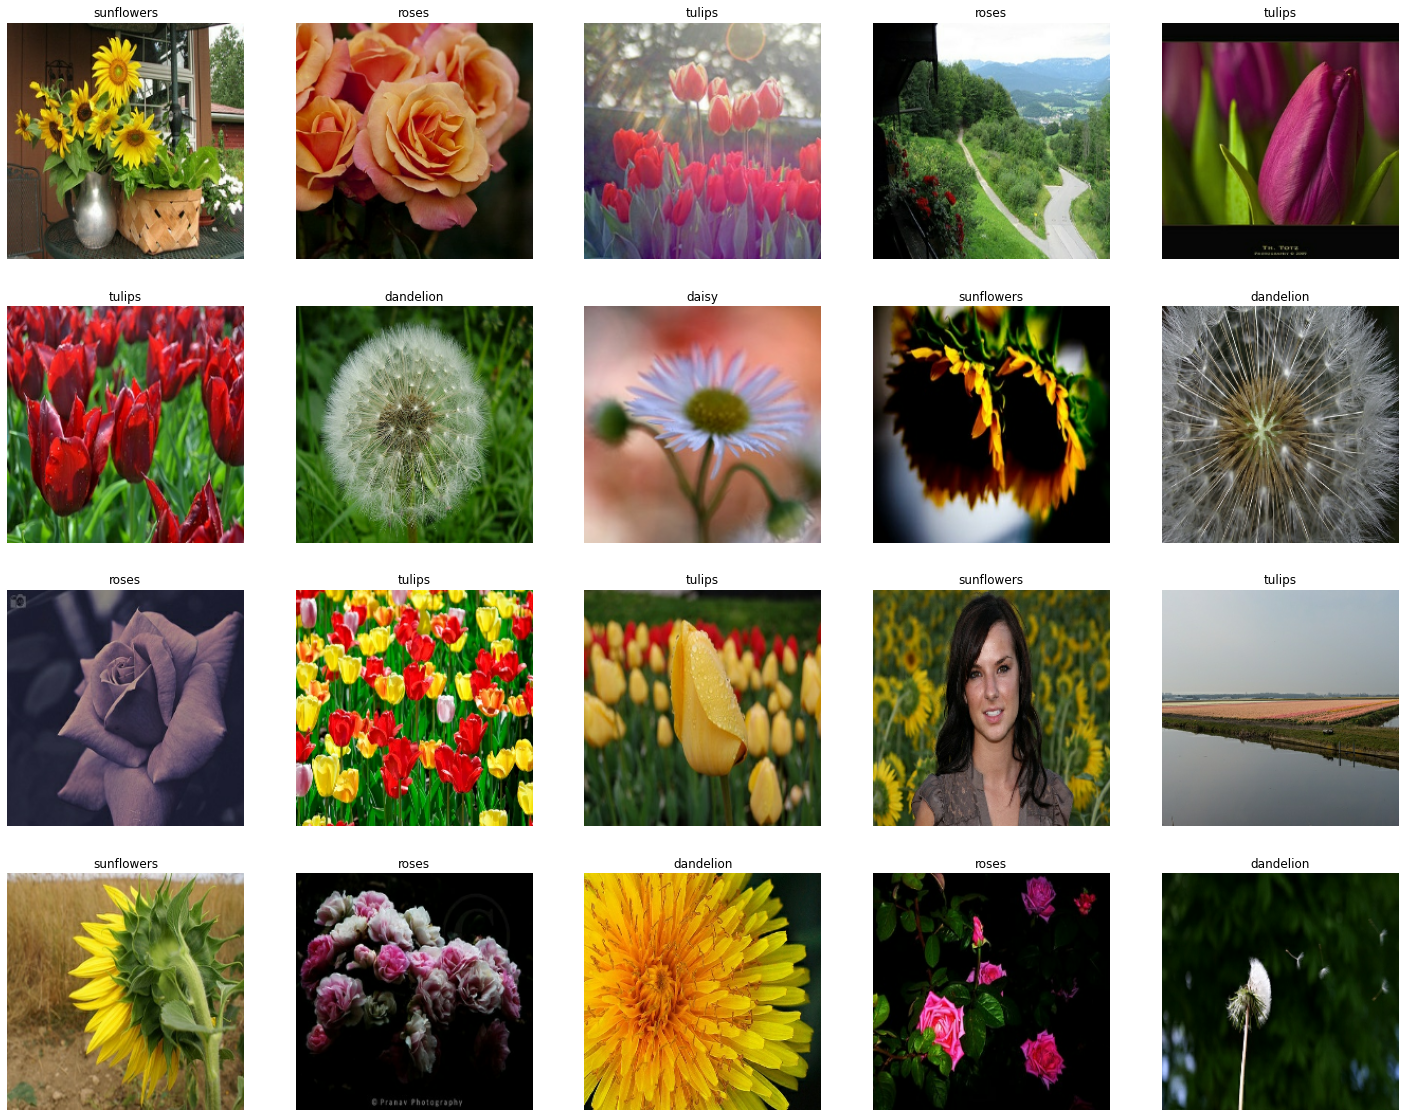

In [42]:
validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch().batch(20) #20 images, 20 labels in every batch 
validation_batch = iter(validation_dataset)

for image, label in validation_batch:
    print(image.numpy().shape, label.numpy().shape)
    print(type(image.numpy()), type(label.numpy()))
    print(label.numpy())
    break
    
image_batch, label_batch = next(validation_batch) # accept the first batch
label_batch = label_batch.numpy()

plt.figure(figsize=(25, 20)) #the size of whole figure
for i in range(20):
  ax = plt.subplot(4, 5, i+1) #the whole figure has 4 rows, 5 columns figures, this is i+1 figure
  #plt.imshow(image_batch[i].numpy().astype("uint8"))  #when image Tensor is the type of Uint8
  plt.imshow(image_batch[i].numpy())
  index = label_batch[i]  #5 classes in[0,4]
  plt.title(CLASSES[index])
  plt.axis("off")

In [43]:
strategy = tf.distribute.MirroredStrategy(devices=None) #Use all available GPUs or CPU
print("REPLICAS:", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
REPLICAS: 1


In [44]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
#To come true learning rate schedule in a epoch by many steps(Dataset_examples//Batch_Size)
#The step argument will be reset zero after a epoch
    def __init__(self, initial_learning_rate):
        self.initial_learning_rate = initial_learning_rate
  
    def __call__(self, step):
        return self.initial_learning_rate / (step + 1)

LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
    
    
def scheduler_epoch(epoch, learning_rate):
    if epoch < LR_RAMPUP_EPOCHS:
        learning_rate = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        learning_rate = LR_MAX
    else:
        learning_rate = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return learning_rate

class LearningRate_with_MultiOptimizer(tf.keras.callbacks.Callback):
    def __init__(self, schedule, verbose=0): # 0:quiet  1:update message
        super(LearningRate_with_MultiOptimizer, self).__init__()
        self.schedule = schedule
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        i = 0
        pretrained_weight = [1.0, 1.0, 0.2, 0.2, 0.008, 0.016, 0.024, 0.032, 0.04, 0.06, 0.06, 0.10, 0.12, 0.14, 0.16, 0.20, 0.24, 0.28, 0.32, 0.36, 0.2]
        for item in self.model.optimizer.optimizer_specs:
            learning_rate = float(tf.keras.backend.get_value(item['optimizer'].learning_rate))
            learning_rate = self.schedule(epoch, learning_rate) * pretrained_weight[i]
            i = i + 1
            tf.keras.backend.set_value(item['optimizer'].learning_rate, tf.keras.backend.get_value(learning_rate))
            
            if self.verbose >0:
                print('\nEpoch {}, learning_rate {}'.format((epoch+1),learning_rate))

                
lr_callback = LearningRate_with_MultiOptimizer(scheduler_epoch, verbose=1)


In [52]:
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.optimizers import MultiOptimizer

#os.environ['TF_KERAS'] = '1' # The order of code should not be wrong
#from keras_adamw import AdamW

with strategy.scope():
    pretrained_model = tf.keras.applications.MobileNetV2(
        weights = 'imagenet',
        include_top = False,
        input_shape = [*IMG_SIZE,3]
    )
    pretrained_model.trainable = True #Open Fine-Tuning

    model = tf.keras.Sequential(
        [
            tf.keras.layers.Lambda(lambda data: tf.keras.applications.mobilenet.preprocess_input(
                tf.cast(data, tf.float32)), input_shape = [*IMG_SIZE, 3]),
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(16, activation='relu', name='flower_dense'),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax', name='flower_prob')
        ]
    )
    
    layer_wise_optimizer = {
        # Clasification head
        'flower_prob': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'flower_prob'),
        #AdamW has got 'learning_rate', 'lr' arguments.
        'flower_dense': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'flower_dense'),
        # Pretrained layers
        'block_1_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b1'),
        'block_2_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b2'),
        'block_3_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b3'),
        'block_4_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b4'),
        'block_5_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b5'),
        'block_6_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b6'),
        'block_7_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b7'),
        'block_8_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b8'),
        'block_9_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b9'),
        'block_10_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b10'),
        'block_11_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b11'),
        'block_12_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b12'),
        'block_13_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b13'),
        'block_14_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b14'),
        'block_15_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b15'),
        'block_16_': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'b16'),
        # these layers do not have stable identifiers in tf.keras.applications.MobileNetV2
        'conv': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'c1'),
        'Conv': AdamW(learning_rate=LR_MAX, weight_decay=0.01, name = 'c2')
    }

    optimiers_and_layers = [
                            (layer_wise_optimizer['flower_dense'], model.layers[3]),
                            (layer_wise_optimizer['flower_prob'], model.layers[4]),
                            (layer_wise_optimizer['Conv'], pretrained_model.layers[1:3]),
                            (layer_wise_optimizer['conv'], pretrained_model.layers[4:9]),
                            (layer_wise_optimizer['block_1_'], pretrained_model.layers[9:18]),
                            (layer_wise_optimizer['block_2_'], pretrained_model.layers[18:27]),
                            (layer_wise_optimizer['block_3_'], pretrained_model.layers[27:36]),
                            (layer_wise_optimizer['block_4_'], pretrained_model.layers[36:45]),
                            (layer_wise_optimizer['block_5_'], pretrained_model.layers[45:54]),
                            (layer_wise_optimizer['block_6_'], pretrained_model.layers[54:63]),
                            (layer_wise_optimizer['block_7_'], pretrained_model.layers[63:72]),
                            (layer_wise_optimizer['block_8_'], pretrained_model.layers[72:81]),
                            (layer_wise_optimizer['block_9_'], pretrained_model.layers[81:90]),
                            (layer_wise_optimizer['block_10_'], pretrained_model.layers[90:98]),
                            (layer_wise_optimizer['block_11_'], pretrained_model.layers[98:107]),
                            (layer_wise_optimizer['block_12_'], pretrained_model.layers[107:116]),
                            (layer_wise_optimizer['block_13_'], pretrained_model.layers[116:125]),
                            (layer_wise_optimizer['block_14_'], pretrained_model.layers[125:134]),
                            (layer_wise_optimizer['block_15_'], pretrained_model.layers[134:143]),
                            (layer_wise_optimizer['block_16_'], pretrained_model.layers[143:151]),
                            (layer_wise_optimizer['Conv'], pretrained_model.layers[151:])]

    optimizer = MultiOptimizer(optimiers_and_layers)
    
    
model.compile(
    #optimizer='adam',
    optimizer= optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()

pretrained_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flower_dense (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2,278,565
Trainable params: 2,244,453
No

                                                                                                  
 block_2_project_BN (BatchNorma  (None, 56, 56, 24)  96          ['block_2_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_2_add (Add)              (None, 56, 56, 24)   0           ['block_1_project_BN[0][0]',     
                                                                  'block_2_project_BN[0][0]']     
                                                                                                  
 block_3_expand (Conv2D)        (None, 56, 56, 144)  3456        ['block_2_add[0][0]']            
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, 56, 56, 144)  576        ['block_3_expand[0][0]']         
 ization) 

                                                                                                  
 block_6_depthwise (DepthwiseCo  (None, 14, 14, 192)  1728       ['block_6_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_6_depthwise_BN (BatchNor  (None, 14, 14, 192)  768        ['block_6_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_6_depthwise_relu (ReLU)  (None, 14, 14, 192)  0           ['block_6_depthwise_BN[0][0]']   
                                                                                                  
 block_6_project (Conv2D)       (None, 14, 14, 64)   12288       ['block_6_depthwise_relu[0][0]'] 
          

 block_10_expand (Conv2D)       (None, 14, 14, 384)  24576       ['block_9_add[0][0]']            
                                                                                                  
 block_10_expand_BN (BatchNorma  (None, 14, 14, 384)  1536       ['block_10_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_10_expand_relu (ReLU)    (None, 14, 14, 384)  0           ['block_10_expand_BN[0][0]']     
                                                                                                  
 block_10_depthwise (DepthwiseC  (None, 14, 14, 384)  3456       ['block_10_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_10_

 block_13_project (Conv2D)      (None, 7, 7, 160)    92160       ['block_13_depthwise_relu[0][0]']
                                                                                                  
 block_13_project_BN (BatchNorm  (None, 7, 7, 160)   640         ['block_13_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_expand (Conv2D)       (None, 7, 7, 960)    153600      ['block_13_project_BN[0][0]']    
                                                                                                  
 block_14_expand_BN (BatchNorma  (None, 7, 7, 960)   3840        ['block_14_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_14_

In [98]:
i = -1
for layer in model.layers:
    print(layer.name)
    i = i + 1
    print(i)
    
i = -1
for layer in pretrained_model.layers:
    print(layer.name)
    i = i + 1
    print(i)

lambda_35
0
mobilenetv2_1.00_224
1
global_average_pooling2d_35
2
flower_dense
3
flower_prob
4
input_36
0
Conv1
1
bn_Conv1
2
Conv1_relu
3
expanded_conv_depthwise
4
expanded_conv_depthwise_BN
5
expanded_conv_depthwise_relu
6
expanded_conv_project
7
expanded_conv_project_BN
8
block_1_expand
9
block_1_expand_BN
10
block_1_expand_relu
11
block_1_pad
12
block_1_depthwise
13
block_1_depthwise_BN
14
block_1_depthwise_relu
15
block_1_project
16
block_1_project_BN
17
block_2_expand
18
block_2_expand_BN
19
block_2_expand_relu
20
block_2_depthwise
21
block_2_depthwise_BN
22
block_2_depthwise_relu
23
block_2_project
24
block_2_project_BN
25
block_2_add
26
block_3_expand
27
block_3_expand_BN
28
block_3_expand_relu
29
block_3_pad
30
block_3_depthwise
31
block_3_depthwise_BN
32
block_3_depthwise_relu
33
block_3_project
34
block_3_project_BN
35
block_4_expand
36
block_4_expand_BN
37
block_4_expand_relu
38
block_4_depthwise
39
block_4_depthwise_BN
40
block_4_depthwise_relu
41
block_4_project
42
block_4_

In [99]:
list = [1,1,2,3,4,5,6]
print(list[0:3])

[1, 1, 2]


In [53]:
NUM_TRAINING_IMG = 3303
STEPS_PER_EPOCH = NUM_TRAINING_IMG // BATCH_SIZE
EPOCHS = 5
NUM_VALIDATION_IMG = 367
VALIDATION_STEPS = -(-NUM_VALIDATION_IMG // BATCH_SIZE) #The "-(- // )" trick rounds up instead of down


history = model.fit(get_training_dataset(),
                    steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
                   callbacks=[lr_callback])


Epoch 1, learning_rate 1e-05

Epoch 1, learning_rate 1e-05

Epoch 1, learning_rate 2.0000000000000003e-06

Epoch 1, learning_rate 2.0000000000000003e-06

Epoch 1, learning_rate 8e-08

Epoch 1, learning_rate 1.6e-07

Epoch 1, learning_rate 2.4000000000000003e-07

Epoch 1, learning_rate 3.2e-07

Epoch 1, learning_rate 4.0000000000000003e-07

Epoch 1, learning_rate 6.000000000000001e-07

Epoch 1, learning_rate 6.000000000000001e-07

Epoch 1, learning_rate 1.0000000000000002e-06

Epoch 1, learning_rate 1.2000000000000002e-06

Epoch 1, learning_rate 1.4000000000000001e-06

Epoch 1, learning_rate 1.6000000000000001e-06

Epoch 1, learning_rate 2.0000000000000003e-06

Epoch 1, learning_rate 2.4000000000000003e-06

Epoch 1, learning_rate 2.8000000000000003e-06

Epoch 1, learning_rate 3.2000000000000003e-06

Epoch 1, learning_rate 3.6000000000000003e-06

Epoch 1, learning_rate 2.0000000000000003e-06
Epoch 1/5


2022-04-13 13:59:14.840752: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


103/103 [==============================] - ETA: 0s - loss: 1.6313 - sparse_categorical_accuracy: 0.2291

2022-04-13 14:03:40.605058: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


103/103 [==============================] - 272s 3s/step - loss: 1.6313 - sparse_categorical_accuracy: 0.2291 - val_loss: 1.6094 - val_sparse_categorical_accuracy: 0.2425

Epoch 2, learning_rate 4e-05

Epoch 2, learning_rate 4e-05

Epoch 2, learning_rate 8.000000000000001e-06

Epoch 2, learning_rate 8.000000000000001e-06

Epoch 2, learning_rate 3.2e-07

Epoch 2, learning_rate 6.4e-07

Epoch 2, learning_rate 9.600000000000001e-07

Epoch 2, learning_rate 1.28e-06

Epoch 2, learning_rate 1.6000000000000001e-06

Epoch 2, learning_rate 2.4000000000000003e-06

Epoch 2, learning_rate 2.4000000000000003e-06

Epoch 2, learning_rate 4.000000000000001e-06

Epoch 2, learning_rate 4.800000000000001e-06

Epoch 2, learning_rate 5.600000000000001e-06

Epoch 2, learning_rate 6.4000000000000006e-06

Epoch 2, learning_rate 8.000000000000001e-06

Epoch 2, learning_rate 9.600000000000001e-06

Epoch 2, learning_rate 1.1200000000000001e-05

Epoch 2, learning_rate 1.2800000000000001e-05

Epoch 2, learning_rate

2022-04-13 14:07:55.257502: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


103/103 [==============================] - 254s 2s/step - loss: 1.6057 - sparse_categorical_accuracy: 0.3140 - val_loss: 1.6093 - val_sparse_categorical_accuracy: 0.2425

Epoch 3, learning_rate 7.000000000000001e-05

Epoch 3, learning_rate 7.000000000000001e-05

Epoch 3, learning_rate 1.4000000000000001e-05

Epoch 3, learning_rate 1.4000000000000001e-05

Epoch 3, learning_rate 5.6e-07

Epoch 3, learning_rate 1.12e-06

Epoch 3, learning_rate 1.6800000000000002e-06

Epoch 3, learning_rate 2.24e-06

Epoch 3, learning_rate 2.8000000000000003e-06

Epoch 3, learning_rate 4.2000000000000004e-06

Epoch 3, learning_rate 4.2000000000000004e-06

Epoch 3, learning_rate 7.000000000000001e-06

Epoch 3, learning_rate 8.400000000000001e-06

Epoch 3, learning_rate 9.800000000000003e-06

Epoch 3, learning_rate 1.1200000000000001e-05

Epoch 3, learning_rate 1.4000000000000001e-05

Epoch 3, learning_rate 1.6800000000000002e-05

Epoch 3, learning_rate 1.9600000000000005e-05

Epoch 3, learning_rate 2.240000

2022-04-13 14:12:01.968402: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


103/103 [==============================] - 246s 2s/step - loss: 1.6092 - sparse_categorical_accuracy: 0.2409 - val_loss: 1.6092 - val_sparse_categorical_accuracy: 0.2425

Epoch 4, learning_rate 0.0001

Epoch 4, learning_rate 0.0001

Epoch 4, learning_rate 2e-05

Epoch 4, learning_rate 2e-05

Epoch 4, learning_rate 8.000000000000001e-07

Epoch 4, learning_rate 1.6000000000000001e-06

Epoch 4, learning_rate 2.4000000000000003e-06

Epoch 4, learning_rate 3.2000000000000003e-06

Epoch 4, learning_rate 4.000000000000001e-06

Epoch 4, learning_rate 6e-06

Epoch 4, learning_rate 6e-06

Epoch 4, learning_rate 1e-05

Epoch 4, learning_rate 1.2e-05

Epoch 4, learning_rate 1.4000000000000001e-05

Epoch 4, learning_rate 1.6000000000000003e-05

Epoch 4, learning_rate 2e-05

Epoch 4, learning_rate 2.4e-05

Epoch 4, learning_rate 2.8000000000000003e-05

Epoch 4, learning_rate 3.2000000000000005e-05

Epoch 4, learning_rate 3.6e-05

Epoch 4, learning_rate 2e-05
Epoch 4/5
103/103 [======================

2022-04-13 14:16:06.464733: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


103/103 [==============================] - 245s 2s/step - loss: 1.6091 - sparse_categorical_accuracy: 0.2476 - val_loss: 1.6091 - val_sparse_categorical_accuracy: 0.2425

Epoch 5, learning_rate 8.2e-05

Epoch 5, learning_rate 8.2e-05

Epoch 5, learning_rate 1.6400000000000002e-05

Epoch 5, learning_rate 1.6400000000000002e-05

Epoch 5, learning_rate 6.56e-07

Epoch 5, learning_rate 1.312e-06

Epoch 5, learning_rate 1.968e-06

Epoch 5, learning_rate 2.624e-06

Epoch 5, learning_rate 3.28e-06

Epoch 5, learning_rate 4.9199999999999995e-06

Epoch 5, learning_rate 4.9199999999999995e-06

Epoch 5, learning_rate 8.200000000000001e-06

Epoch 5, learning_rate 9.839999999999999e-06

Epoch 5, learning_rate 1.1480000000000002e-05

Epoch 5, learning_rate 1.312e-05

Epoch 5, learning_rate 1.6400000000000002e-05

Epoch 5, learning_rate 1.9679999999999998e-05

Epoch 5, learning_rate 2.2960000000000004e-05

Epoch 5, learning_rate 2.624e-05

Epoch 5, learning_rate 2.952e-05

Epoch 5, learning_rate 1.64

2022-04-13 14:20:13.393515: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


103/103 [==============================] - 247s 2s/step - loss: 1.6091 - sparse_categorical_accuracy: 0.2403 - val_loss: 1.6091 - val_sparse_categorical_accuracy: 0.2425


In [130]:
def false_situation():
    return tf.cond(pred = 3 < 3,
                   true_fn= lambda : 2023,
                   false_fn= lambda : LR_MAX)

end = tf.cond(pred= 3 < 3,
        true_fn= lambda:2022,
        false_fn= lambda : false_situation())
print(end)

0.0001


In [132]:
false_situation= tf.cond(pred = 3 < 3,
                   true_fn= lambda : 2023,
                   false_fn= lambda : LR_MAX)

end = tf.cond(pred= 3 < 3,
        true_fn= lambda:2022,
        false_fn= lambda : false_situation)
print(end)

0.0001


In [63]:
optimizer.optimizer_specs[21]['optimizer'].learning_rate

IndexError: list index out of range

In [144]:
for item in optimizer.optimizer_specs:
    print(item['optimizer']) 
    print(float(tf.keras.backend.get_value(item['optimizer'].learning_rate)))

0.0010000000474974513
0.0010000000474974513
0.0005000000237487257
0.0005000000237487257
1.9999999494757503e-05
3.9999998989515007e-05
5.999999848427251e-05
7.999999797903001e-05
9.999999747378752e-05
0.0001500000071246177
0.00019999999494757503
0.0002500000118743628
0.0003000000142492354
0.0003499999875202775
0.00039999998989515007
0.0005000000237487257
0.0006000000284984708
0.000699999975040555
0.0007999999797903001
0.0008999999845400453
0.0005000000237487257


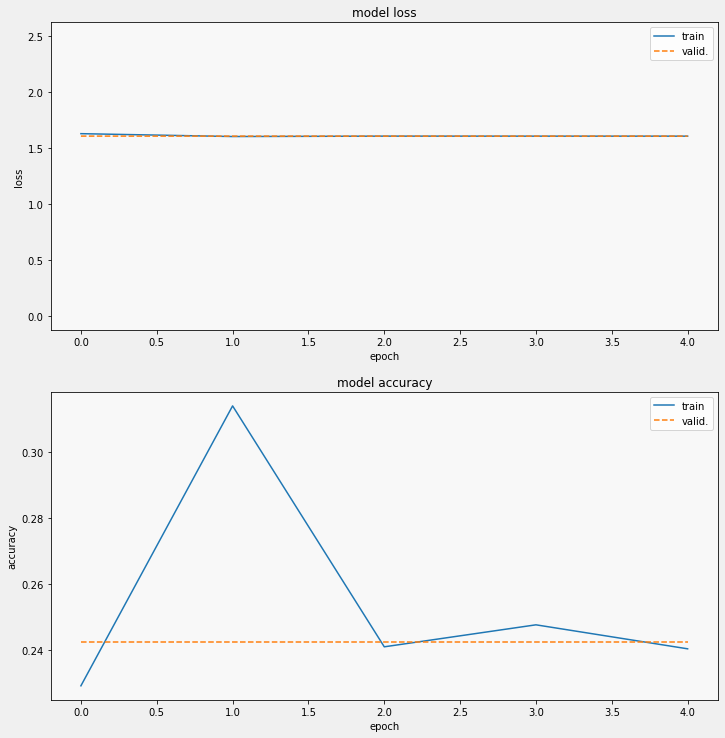

In [54]:
def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
    # zoom_pcent: X autoscales y axis for the last X% of data points
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation, '--')
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    if zoom_pcent is not None:
        ylen = len(training)*(100-zoom_pcent)//100
        ymin = min([min(training[ylen:]), min(validation[ylen:])])
        ymax = max([max(training[ylen:]), max(validation[ylen:])])
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
    
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211, ylim=[0,2.5])
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)


In [55]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMG))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds, steps=VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)


2022-04-13 14:22:07.726755: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Correct   labels:  (367,) [2 0 0 1 1 2 3 4 3 3 4 0 3 4 0 2 3 1 3 3 1 0 4 0 4 4 3 2 1 3 0 4 4 1 4 1 0
 3 0 3 4 2 2 1 3 0 4 0 4 3 3 1 4 3 2 1 3 1 0 1 3 2 3 4 3 2 2 3 1 4 4 1 0 4
 0 3 3 3 2 4 1 4 3 2 0 0 2 4 3 3 0 0 1 3 3 2 3 0 1 3 0 1 3 3 2 3 3 2 1 1 4
 1 2 4 0 3 4 1 0 4 2 2 4 1 3 1 1 1 4 4 2 1 1 4 3 1 0 4 3 0 0 3 3 0 4 2 1 3
 2 4 2 3 0 2 3 0 1 3 0 3 1 4 3 1 0 4 0 2 1 2 3 4 0 2 0 2 2 4 1 4 4 1 4 0 3
 1 0 0 0 1 4 4 3 1 4 2 1 1 4 0 3 2 1 1 1 1 2 4 2 4 0 2 3 3 3 1 3 3 3 3 0 1
 3 4 0 1 1 4 3 2 4 0 3 1 4 4 0 0 1 2 0 2 2 0 4 0 3 1 1 3 1 3 4 1 2 2 1 3 0
 3 0 1 0 2 3 3 2 2 1 3 1 2 3 0 4 4 4 2 1 1 4 4 3 4 3 0 1 2 0 4 0 3 4 3 3 4
 4 2 0 1 0 1 0 3 2 2 4 2 4 2 4 3 1 4 4 4 2 1 2 2 3 0 1 1 0 4 3 4 4 2 1 2 2
 3 3 2 1 0 1 4 4 3 3 1 4 3 4 2 1 0 3 4 0 3 2 3 0 3 0 2 2 1 1 0 3 4 3]
Predicted labels:  (367,) [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

In [56]:
cm_probabilities.shape

(367, 5)

/Users/zhuzhirui/opt/anaconda3/envs/Pure_TensorFlow_2_8/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


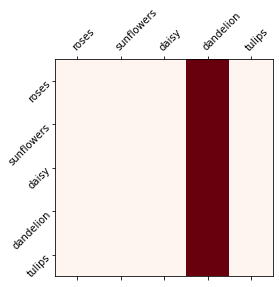

f1 score: 0.078, precision: 0.049, recall: 0.200


In [59]:
def display_confusion_matrix(cmat, score, precision, recall):
    #plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES)
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #titlestring = ""
    #if score is not None:
    #    titlestring += 'f1 = {:.3f} '.format(score)
    #if precision is not None:
    #    titlestring += '\nprecision = {:.3f} '.format(precision)
    #if recall is not None:
    #    titlestring += '\nrecall = {:.3f} '.format(recall)
    #if len(titlestring) > 0:
    #    ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))